In [130]:
!date

Wed Apr 16 05:03:56 PM EDT 2025


In [131]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [132]:
import os
import numpy as np
import pandas as pd
import ants
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm

In [133]:
def load_pickle(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as file:
            loaded_dict = pickle.load(file)
    return loaded_dict

In [134]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n = len(subs)
n = 14
n

14

In [135]:
a = os.listdir('../Data/StudyForrest/ensembles_last_CVAE/')
a.sort()
a

['.ipynb_checkpoints',
 'DeepCor-ABCD-v1',
 'DeepCor-ABCD-v2',
 'DeepCor-ABCD-v3',
 'DeepCor-Forrest-ablations-00-baseline',
 'DeepCor-Forrest-ablations-01-nosummation',
 'DeepCor-Forrest-ablations-02-noAdvRemoval',
 'DeepCor-Forrest-ablations-03-noNCC',
 'DeepCor-Forrest-ablations-03-noTC',
 'DeepCor-Forrest-ablations-04-noCoords',
 'DeepCor-Forrest-ablations-06-noAll',
 'DeepCor-Forrest-ablations-06-noAll-v2',
 'DeepCor-Forrest-face-v1',
 'YuOrig-00-DataloaderFix',
 'YuOrig-00-orig',
 'slurm_files',
 'test',
 'test-lin']

In [413]:
analysis_name = 'DeepCor-Forrest-face-v1'
#analysis_name = 'DeepCor-ABCD-v1'
#analysis_name = 'DeepCor-Forrest-ablations-06-noAll'
#analysis_name = 'DeepCor-Forrest-ablations-06-noAll-v2'
#analysis_name = 'YuOrig-00-orig'
#analysis_name = 'DeepCor-Forrest-ablations-00-baseline'
analysis_name = 'DeepCor-Forrest-ablations-06-noAll-v2'
analysis_dir = os.path.join('../Data/StudyForrest/ensembles_last_CVAE/',analysis_name)

In [414]:
#dict_keys(['recon', 'recon_coords', 'signal', 'signal_coords', 'noise', 'noise_coords', 'ffa', 'ffa_coords', 'ffa_compcorr', 'face_reg', 'place_reg', 'confounds'])

In [415]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
n = len(subs)
events_fn_temp = '../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'

In [416]:
def get_regs(events_fn):
    from nilearn.glm.first_level import make_first_level_design_matrix

    events = pd.read_csv(events_fn,delimiter='\t')

    t_r = 2.0 
    #n_scans = epi.shape[-1]
    n_scans = 156
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

    #face_reg = X1['face'].values
    #place_reg = X1[['body', 'house', 'object', 'scene', 'scramble']].values.sum(axis=1)

    #face_reg = X1[['face','body']].values.sum(axis=1)
    face_reg = X1[['face']].values.sum(axis=1)
    place_reg = X1[['house','scene']].values.sum(axis=1)
    
    return face_reg,place_reg

In [417]:
def get_sub_data(s,r,return_type='corr'):
    output_files = [os.path.join(analysis_dir,val) for val in os.listdir(analysis_dir) if val.startswith(f'outputs_S{s}_R{r}_')]
    vals_ffa = load_pickle(output_files[0])['ffa']
    vals_compcor = load_pickle(output_files[0])['ffa_compcorr']
    #face_reg = load_pickle(output_files[0])['face_reg']
    face_reg, place_reg = get_regs(events_fn_temp.format(sub=subs[s],r=r))    
    vals_signals = np.array([load_pickle(output_file)['signal'] for output_file in output_files])
    vals_signals_med = np.median(vals_signals,0)
    #vals_signals_med = np.average(vals_signals,0)

    r_ffa = np.array([np.corrcoef(vals_ffa[v,:],face_reg)[0,1] for v in range(vals_ffa.shape[0])]).mean()
    r_compcor = np.array([np.corrcoef(vals_compcor[v,:],face_reg)[0,1] for v in range(vals_ffa.shape[0])]).mean()
    r_fg = np.array([np.corrcoef(vals_signals_med[v,:],face_reg)[0,1] for v in range(vals_ffa.shape[0])]).mean()
    
    if return_type=='corr':
        return (r_ffa,r_compcor,r_fg)
    elif return_type=='vals':
        return vals_ffa,vals_compcor,vals_signals_med,vals_signals,face_reg

In [418]:
do_plot_indiv = False
if do_plot_indiv==True:
    for s in range(14):
        for r in [1,2,3,4]:
            vals_ffa,vals_compcor,vals_signals_med,vals_signals,face_reg = get_sub_data(s,r,return_type='vals')

            plt.figure(figsize=(25,5))
            plt.subplot(1,4,1)
            plt.plot(vals_ffa.mean(axis=0))
            plt.plot(face_reg)
            c = np.corrcoef(vals_ffa.mean(axis=0),face_reg)[0,1]
            plt.title(f'NoDenoise, r={c:.2f}')
            plt.ylim(-1.5,1.5)

            plt.subplot(1,4,2)
            plt.plot(vals_compcor.mean(axis=0))
            plt.plot(face_reg)
            c = np.corrcoef(vals_compcor.mean(axis=0),face_reg)[0,1]
            plt.title(f'CompCor, r={c:.2f}')
            plt.ylim(-1.5,1.5)

            plt.subplot(1,4,3)
            plt.plot(vals_signals_med.mean(axis=0))
            plt.plot(face_reg)
            c = np.corrcoef(vals_signals_med.mean(axis=0),face_reg)[0,1]
            plt.title(f'DeepCor, r={c:.2f}')
            plt.ylim(-1.5,1.5)

            plt.subplot(1,4,4)
            for i in range(vals_signals.shape[0]):
                plt.plot(vals_signals[i,:,:].mean(axis=0),alpha=.5)
            plt.plot(face_reg)

            plt.suptitle(f'S{s}/R{r}')

In [419]:
nsubs = n
#corr_res = np.array([[get_sub_data(s,r) for r in [1,2,3,4]] for s in range(nsubs)])
corr_res = np.array([[get_sub_data(s,r) for r in [1,2,3,4]] for s in range(nsubs)])
corr_res.shape

(14, 4, 3)

[0.15110738 0.16889445 0.21273229]


([<matplotlib.axis.XTick at 0x7fdb582785b0>,
 [Text(0, 0, 'NoDenoise'), Text(1, 0, 'CompCor'), Text(2, 0, 'DeepCor')])

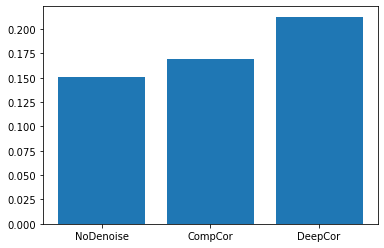

In [420]:
ys = corr_res.mean(axis=0).mean(axis=0)
print(ys)
xs = [0,1,2]
plt.bar(xs,ys)
plt.xticks(xs,labels=['NoDenoise','CompCor','DeepCor'])

In [421]:
corr_res.shape

(14, 4, 3)

In [422]:
def pretty_t_test(vec1,vec2,ttl):
    from scipy.stats import ttest_rel
    #vec1 = vec_compcor
    #vec2 = vec_ffa
    #ttl = 'compcor > nodenoise: '
    t,p = ttest_rel(vec1,vec2)
    degf = len(vec1)-1
    diff = vec1.mean()-vec2.mean()
    

    print(f'{ttl} ΔM={diff:.2f}, t({int(degf)}) = {t:.2f}, p = {p:.3f}')

In [423]:
np.save(file=f'../Data/{analysis_name}',arr=corr_res)

In [424]:
vec_ffa = corr_res.mean(axis=1)[:,0]
vec_compcor = corr_res.mean(axis=1)[:,1]
vec_deepcor = corr_res.mean(axis=1)[:,2]

In [425]:
print(vec_ffa.mean())
print(vec_compcor.mean())
print(vec_deepcor.mean())

0.15110737862001075
0.1688944511838288
0.21273228795613042


In [426]:
pretty_t_test(vec_compcor,vec_ffa,'CompCor > NoDenoise: ')
pretty_t_test(vec_deepcor,vec_ffa,'DeepCor > NoDenoise: ')
pretty_t_test(vec_deepcor,vec_compcor,'DeepCor > CompCor: ')

CompCor > NoDenoise:  ΔM=0.02, t(13) = 4.66, p = 0.000
DeepCor > NoDenoise:  ΔM=0.06, t(13) = 4.05, p = 0.001
DeepCor > CompCor:  ΔM=0.04, t(13) = 2.73, p = 0.017


In [427]:
d1=vec_compcor.mean()-vec_ffa.mean()
d2=vec_deepcor.mean()-vec_compcor.mean()
print(d1)
print(d2)
print(f'Correlation improvement: {d2/d1:.2f}x')

0.017787072563818035
0.04383783677230163
Correlation improvement: 2.46x


In [428]:
def plot_scatter(vec1,vec2,xlabel='',ylabel='',title=''):
#    plt.figure(figsize=(8, 6))
    plt.scatter(vec1, vec2, color='blue', label='Data points',s=150)
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)

    # Adding the parity line (where y = x)
    # Determine the limits for the line based on the data range:
    min_val = min(np.min(vec1), np.min(vec2))
    max_val = max(np.max(vec1), np.max(vec2))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Parity line (y=x)')

    # Add labels and title
    plt.xlabel(xlabel,fontsize=16,fontweight='bold')
    plt.ylabel(ylabel,fontsize=16,fontweight='bold')
    plt.legend()
    plt.grid(True)
    #plt.show()


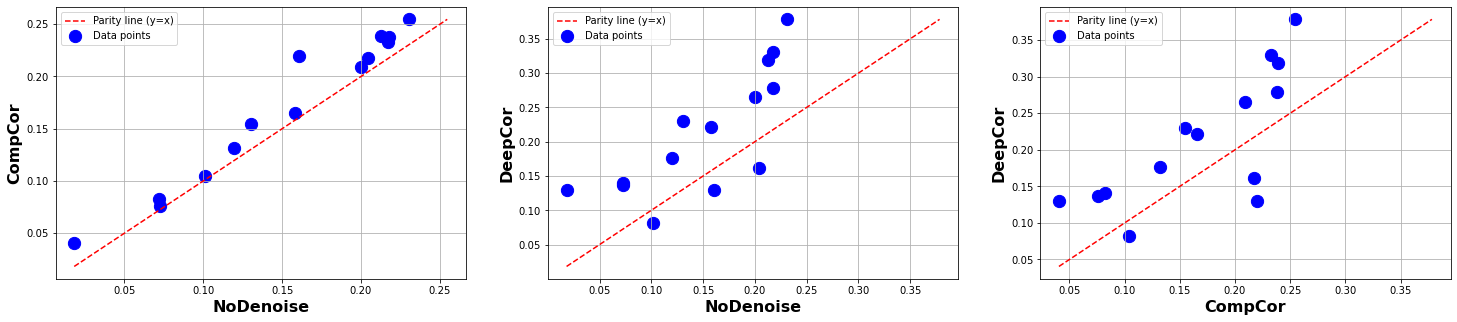

In [429]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1);plot_scatter(vec_ffa,vec_compcor,xlabel='NoDenoise',ylabel='CompCor',title='')
plt.subplot(1,3,2);plot_scatter(vec_ffa,vec_deepcor,xlabel='NoDenoise',ylabel='DeepCor',title='')
plt.subplot(1,3,3);plot_scatter(vec_compcor,vec_deepcor,xlabel='CompCor',ylabel='DeepCor',title='')

In [430]:
def pretty_bar_plot(arrs,group_labels,bar_color,title=''):
    # Organize data into a list for easy looping
    #arrs = [face_preproc_vals, face_compcor_vals, face_signal_vals]
    #group_labels = ['Face Preproc', 'Face CompCor', 'Face Signal']

    # Calculate means and standard deviations
    means = np.array([arr.mean() for arr in arrs])
    stds = np.array([arr.std() for arr in arrs])
    stds = stds / np.sqrt(len(arrs[0]))
    xs = np.arange(len(arrs))  # positions for each bar

    # Set the desired color for the bars (change this variable as needed)
    #bar_color = 'red'  # e.g., 'red', 'blue', 'green', etc.

    # Create the figure with appropriate dimensions for publication
    #plt.figure(figsize=(8, 6))

    # Plot bars with error bars
    bar_container = plt.bar(xs, means, yerr=stds, capsize=5,
                            color=bar_color, edgecolor='black', alpha=0.5)

    # Overlay individual data points with jitter to avoid overlap.
    for i, arr in enumerate(arrs):
        # Add a little random jitter to the x-positions so points don't overlay exactly.
        jitter = np.random.normal(0, 0.1, size=len(arr))
        plt.scatter(np.full(len(arr), xs[i]) + jitter, arr,
                    color='black', zorder=5, s=200, alpha=0.3)

    # Increase font sizes and set text bold for clarity in print.
    plt.xticks(xs, group_labels, fontsize=16, fontweight='bold')
    #plt.xlabel('Processing Type', fontsize=18, fontweight='bold')
    plt.ylabel('Corr. with Regressor', fontsize=18, fontweight='bold')
    #plt.title('Comparison of Face Processing Methods', fontsize=20, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Optionally, remove top and right borders for a clean aesthetic.
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Bold tick labels on the y-axis as well.
    for label in ax.get_yticklabels():
        label.set_fontsize(16)
        label.set_fontweight('bold')

    plt.title(title,fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [431]:
face_preproc_vals = corr_res.mean(axis=1)[:,0]
face_compcor_vals = corr_res.mean(axis=1)[:,1]
face_signal_vals = corr_res.mean(axis=1)[:,2]

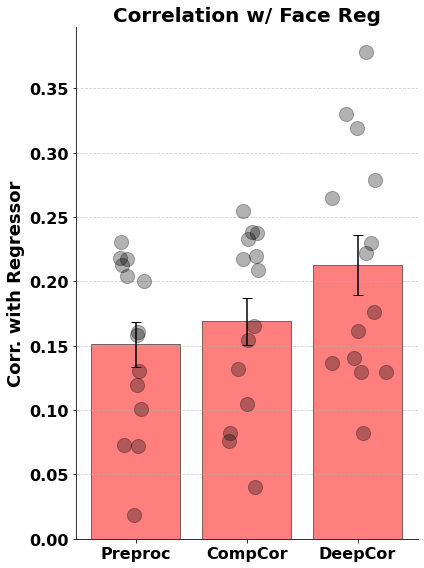

In [432]:
arrs = [face_preproc_vals,face_compcor_vals,face_signal_vals]
group_labels = ['Preproc','CompCor','DeepCor']
bar_color = 'red'
plt.figure(figsize=(6,8))
pretty_bar_plot(arrs,group_labels,bar_color,title='Correlation w/ Face Reg')

In [433]:
def get_contrast_val(Y):
    from nilearn.glm.first_level import make_first_level_design_matrix

    events = pd.read_csv(events_fn_temp.format(sub=subs[s],r=r),delimiter='\t')

    t_r = 2.0 
    n_scans = 156  # the acquisition comprises 128 scans
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #
    
    Y = (Y-Y.mean(axis=1)[:,np.newaxis])/Y.std(axis=1)[:,np.newaxis] # Z score values
    Y = Y.transpose()
    X = X1.values
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    beta = beta.values

    #contrast_vector = np.array([2,2,-1,-1,-1,-1,0,0,0,0]) # Faces + Bodies > Rest
    contrast_vector = np.array([-1,5,-1,-1,-1,-1,0,0,0,0]) # Faces > Rest
    contrast_values = beta @ contrast_vector
    return contrast_values.mean()

In [434]:
contrast_res = []
for s in range(nsubs):
    temp = []
    for r in [1,2,3,4]:
        vals_ffa,vals_compcor,vals_signals_med,vals_signals,face_reg = get_sub_data(s,r,return_type='vals')
        temp.append([get_contrast_val(val) for val in [vals_ffa,vals_compcor,vals_signals_med]])
    contrast_res.append(temp)
contrast_res = np.array(contrast_res)

In [435]:
contrast_res.shape

(14, 4, 3)

In [436]:
contrast_res_avg = contrast_res.mean(axis=1)

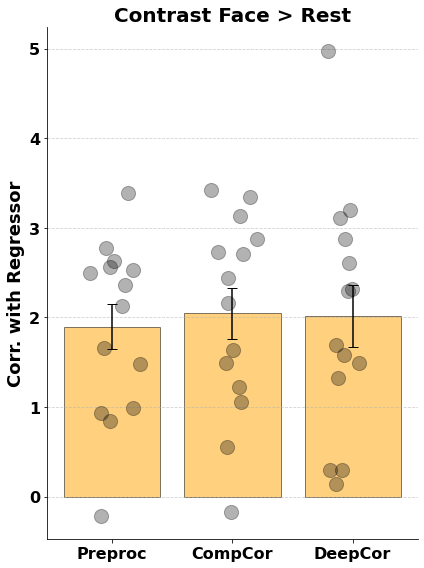

In [437]:
arrs = [contrast_res_avg[:,0],contrast_res_avg[:,1],contrast_res_avg[:,2]]
group_labels = ['Preproc','CompCor','DeepCor']
bar_color = 'orange'
plt.figure(figsize=(6,8))
pretty_bar_plot(arrs,group_labels,bar_color,title='Contrast Face > Rest')

In [438]:
pretty_t_test(contrast_res_avg[:,1],contrast_res_avg[:,0],'Contrast: CompCor > NoDenoise: ')
pretty_t_test(contrast_res_avg[:,2],contrast_res_avg[:,0],'Contrast: DeepCor > NoDenoise: ')
pretty_t_test(contrast_res_avg[:,2],contrast_res_avg[:,1],'Contrast: DeepCor > CompCor: ')

Contrast: CompCor > NoDenoise:  ΔM=0.15, t(13) = 2.12, p = 0.053
Contrast: DeepCor > NoDenoise:  ΔM=0.12, t(13) = 0.52, p = 0.611
Contrast: DeepCor > CompCor:  ΔM=-0.03, t(13) = -0.11, p = 0.916


In [439]:
d1=contrast_res_avg[:,1].mean()-contrast_res_avg[:,0].mean()
d2=contrast_res_avg[:,2].mean()-contrast_res_avg[:,1].mean()
print(d1)
print(d2)

0.14625523402316465
-0.02881948926365574


In [440]:
print(f'Face selectivity improvement: {d2/d1:.2f}x')

Face selectivity improvement: -0.20x


<BarContainer object of 14 artists>

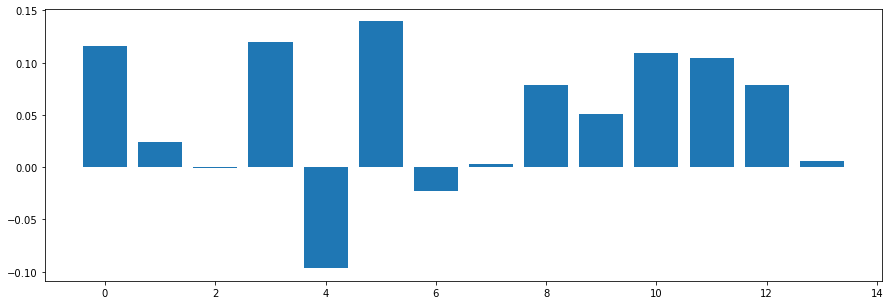

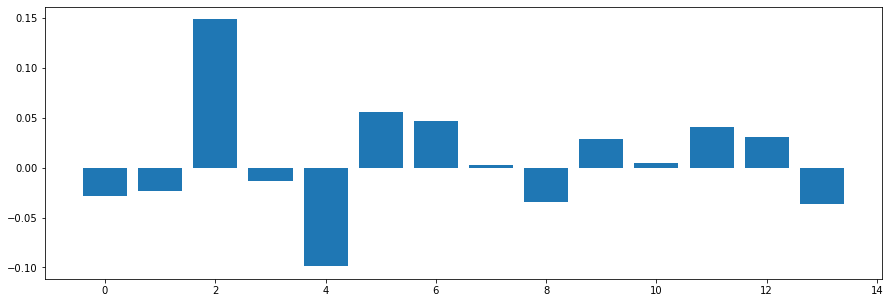

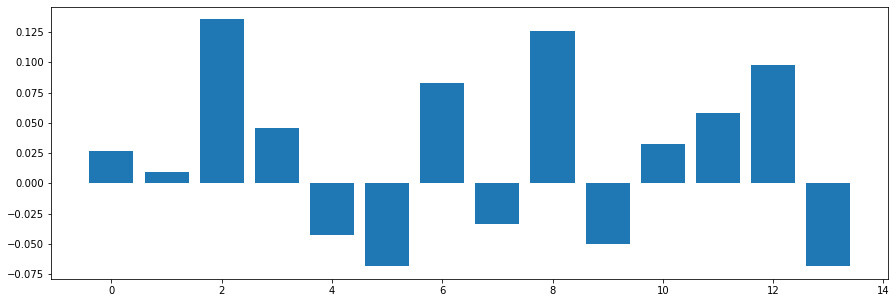

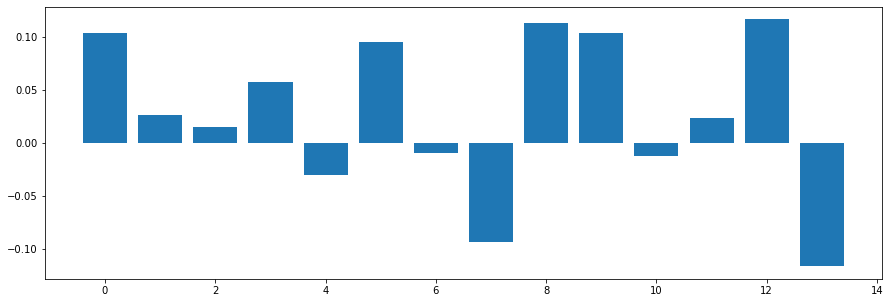

In [380]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(nsubs),corr_res[:,0,2]-corr_res[:,0,1])

plt.figure(figsize=(15,5))
plt.bar(np.arange(nsubs),corr_res[:,1,2]-corr_res[:,1,1])

plt.figure(figsize=(15,5))
plt.bar(np.arange(nsubs),corr_res[:,2,2]-corr_res[:,2,1])

plt.figure(figsize=(15,5))
plt.bar(np.arange(nsubs),corr_res[:,3,2]-corr_res[:,3,1])

In [381]:
arr1=np.load('../Data/YuOrig-00-orig.npy')
arr2=np.load('../Data/DeepCor-Forrest-face-v1.npy')

In [382]:
vec1=arr1.mean(axis=1)[:,2]-arr1.mean(axis=1)[:,1]
vec2=arr2.mean(axis=1)[:,2]-arr2.mean(axis=1)[:,1]

In [383]:
vec1.mean()

0.028052698900676187

In [384]:
vec2.mean()

0.07132918188813377

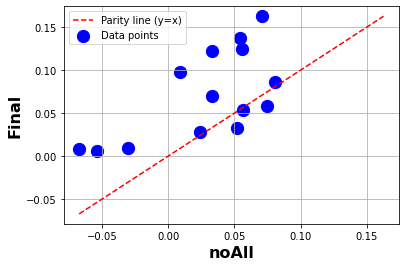

In [385]:
plot_scatter(vec1,vec2,xlabel='noAll',ylabel='Final',title='')